In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df.set_index("date", inplace=True)
df.index = pd.to_datetime(df.index)
print(df.head())

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000


In [3]:
df_test = pd.read_csv('DailyDelhiClimateTest.csv')
df_test.set_index("date", inplace=True)
df_test.index = pd.to_datetime(df_test.index)
print(df_test.head())

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.000000
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333


In [4]:
print(df['meantemp'])

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
                ...    
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, Length: 1462, dtype: float64


<AxesSubplot: xlabel='date'>

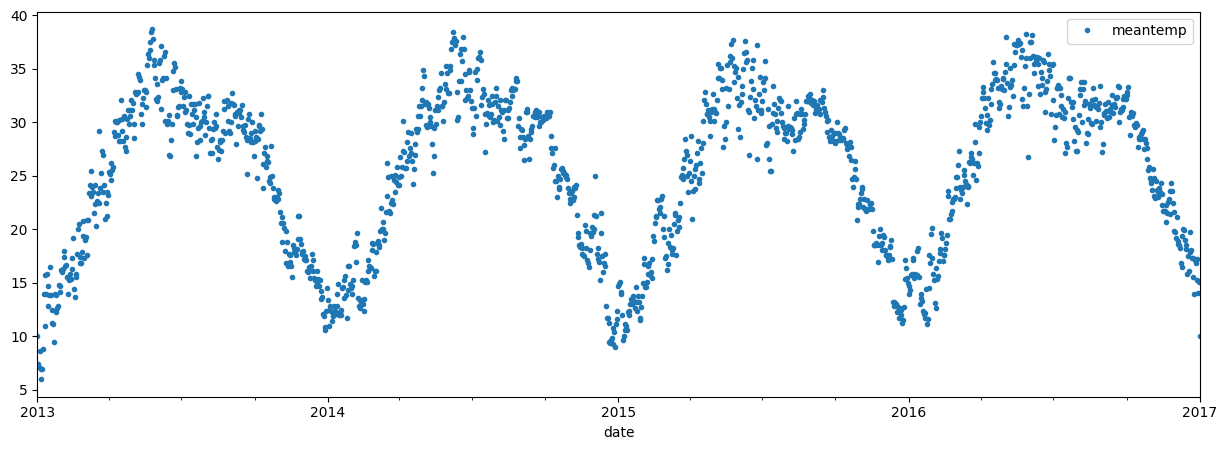

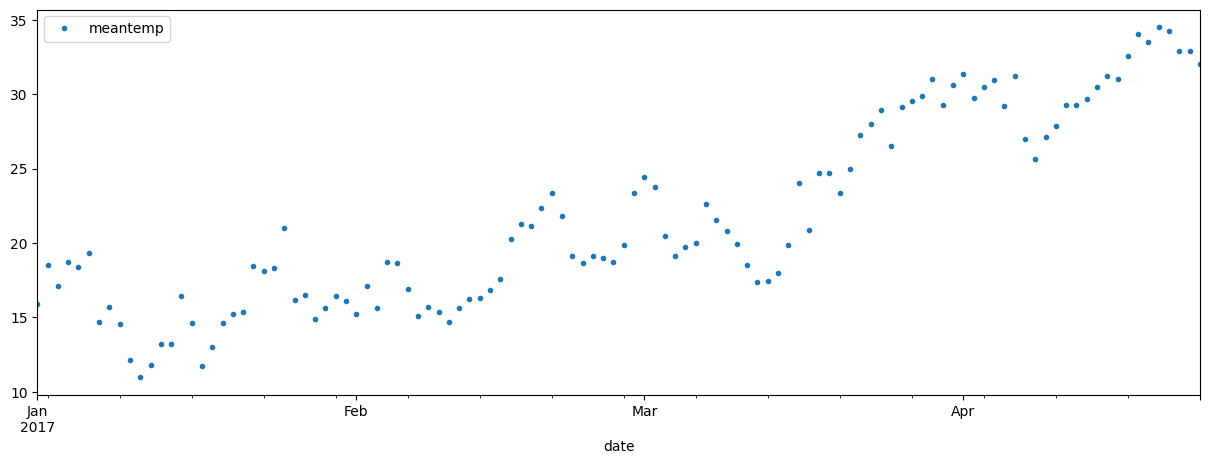

In [5]:
df.plot(y='meantemp', figsize=(15,5), style='.')
df_test.plot(y='meantemp', figsize=(15,5), style='.')

<AxesSubplot: xlabel='date'>

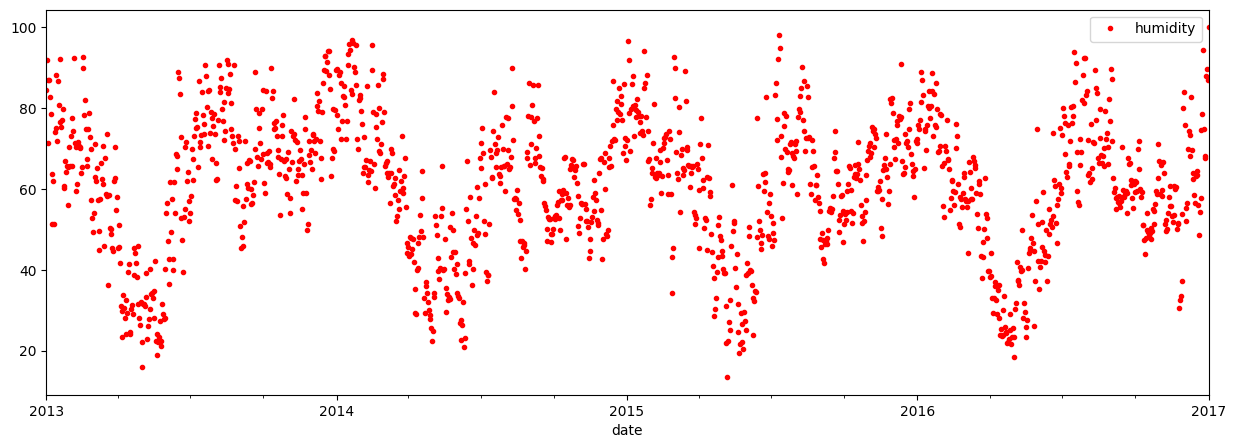

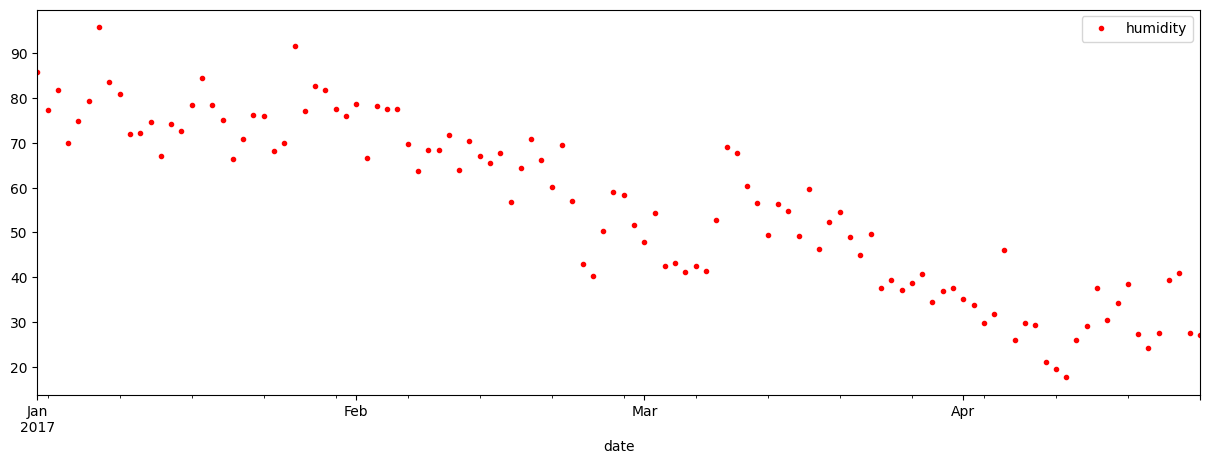

In [6]:
df.plot(y='humidity', figsize=(15,5), style='.', color='red')
df_test.plot(y='humidity', figsize=(15,5), style='.', color='red')

<AxesSubplot: xlabel='date'>

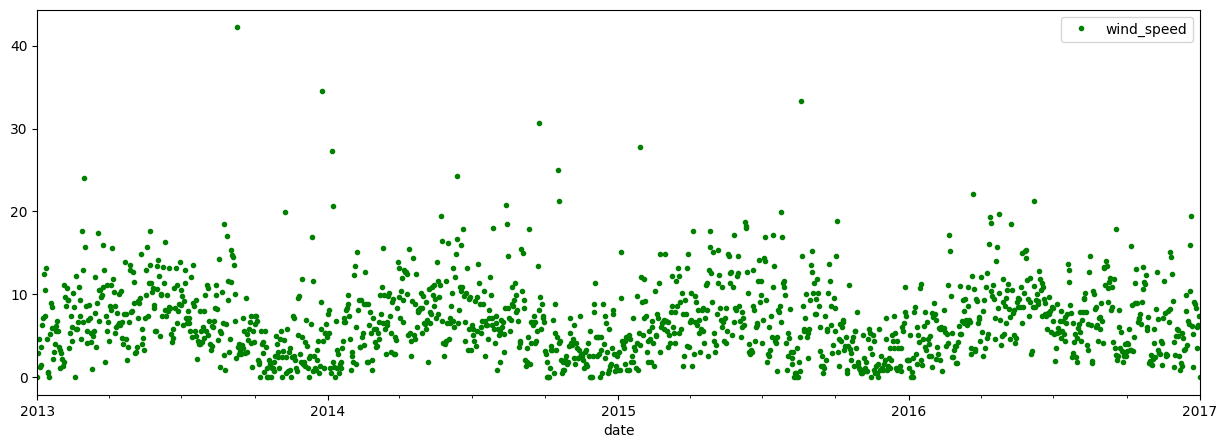

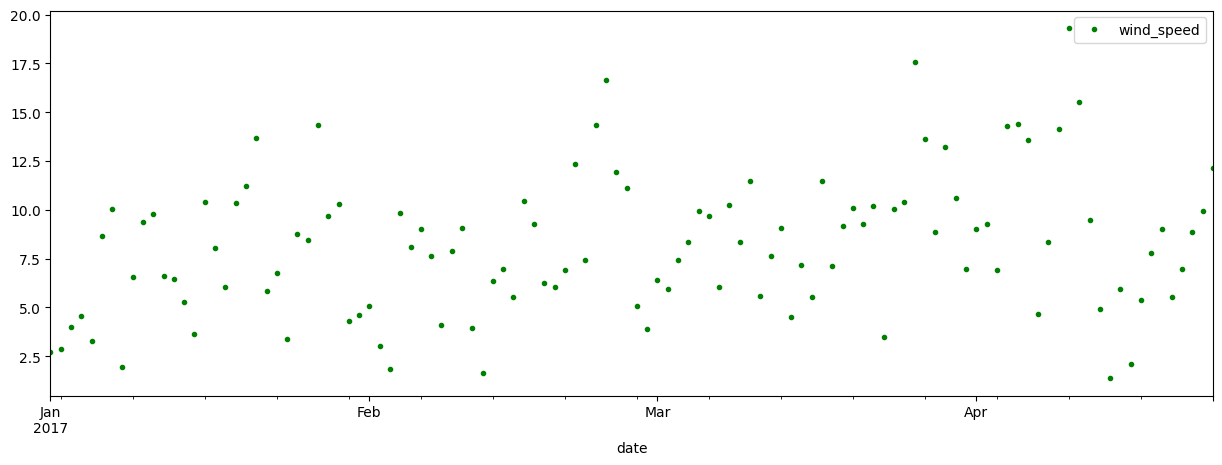

In [7]:
df.plot(y='wind_speed', figsize=(15,5), style='.', color='green')
df_test.plot(y='wind_speed', figsize=(15,5), style='.', color='green')

<AxesSubplot: xlabel='date'>

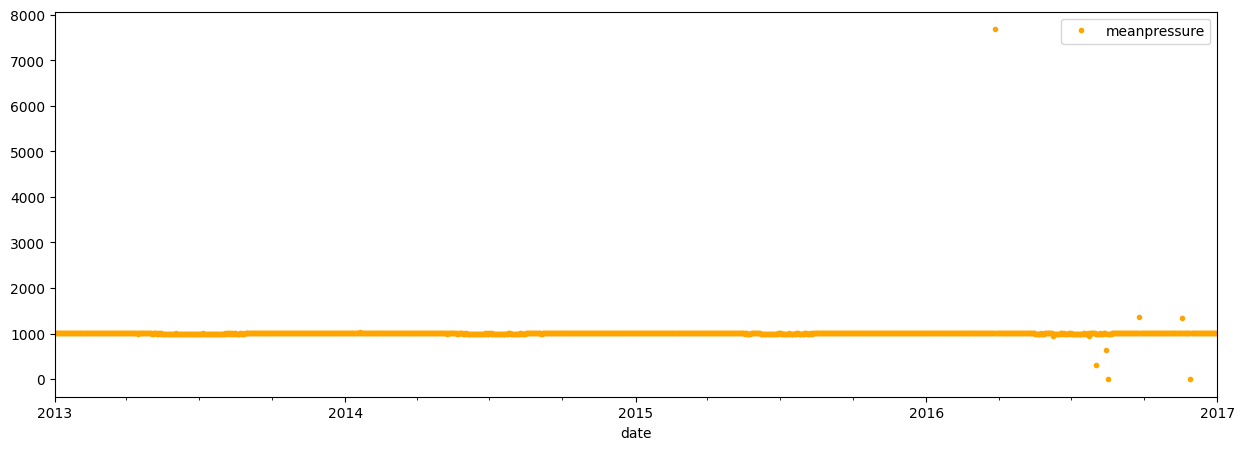

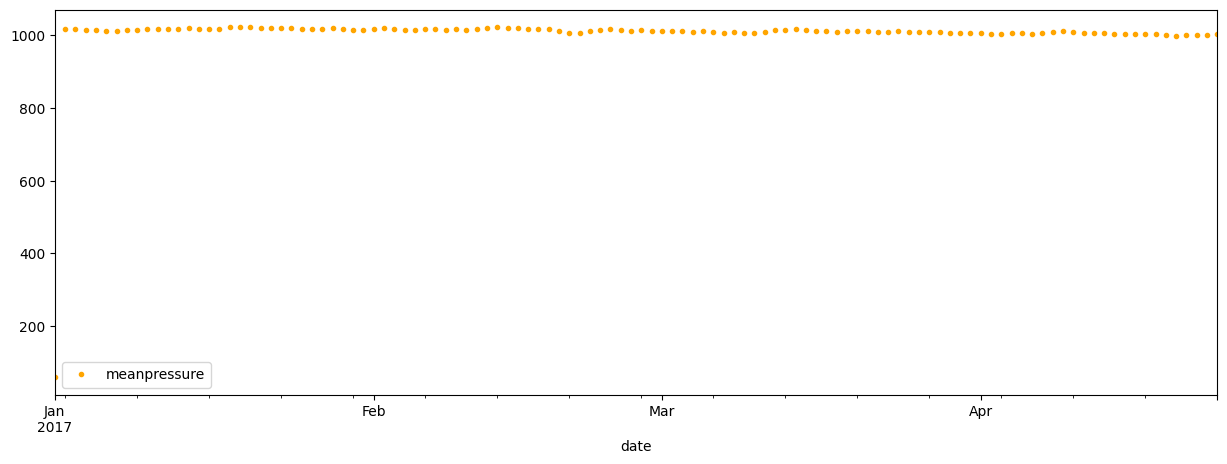

In [8]:
df.plot(y='meanpressure', figsize=(15,5), style='.', color='orange')
df_test.plot(y='meanpressure', figsize=(15,5), style='.', color='orange')

In [9]:
dfcp = df.copy()
dfcp['week'] = dfcp.index.isocalendar().week
dfcp['month'] = dfcp.index.month

dfcp_test = df_test.copy()
dfcp_test['week'] = dfcp_test.index.isocalendar().week
dfcp_test['month'] = dfcp_test.index.month
print(dfcp_test.head())

             meantemp   humidity  wind_speed  meanpressure  week  month
date                                                                   
2017-01-01  15.913043  85.869565    2.743478     59.000000    52      1
2017-01-02  18.500000  77.222222    2.894444   1018.277778     1      1
2017-01-03  17.111111  81.888889    4.016667   1018.333333     1      1
2017-01-04  18.700000  70.050000    4.545000   1015.700000     1      1
2017-01-05  18.388889  74.944444    3.300000   1014.333333     1      1


In [10]:
def get_train_test(features, target, train=dfcp, test=dfcp_test):
    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]

    X_train[features] = X_train[features].astype(np.int64)
    X_test[features] = X_test[features].astype(np.int64)

    return X_train, X_test, y_train, y_test

In [30]:
def visualise_preds(original_frame, X_test, model, target):
    X_test = X_test.copy()
    preds = model.predict(X_test)
    X_test['preds'] = preds

    fig, ax = plt.subplots(figsize=(7, 5))
    X_test.plot(ax=ax, y='preds', color='red')
    original_frame.plot(ax=ax, y=target)

In [11]:
features = ['week', 'month']
target = 'meantemp'

In [12]:
X_train, X_test, y_train, y_test = get_train_test(features, target, train=dfcp, test=dfcp_test)

print(X_train)

            week  month
date                   
2013-01-01     1      1
2013-01-02     1      1
2013-01-03     1      1
2013-01-04     1      1
2013-01-05     1      1
...          ...    ...
2016-12-28    52     12
2016-12-29    52     12
2016-12-30    52     12
2016-12-31    52     12
2017-01-01    52      1

[1462 rows x 2 columns]


C:\Users\Coach\AppData\Local\Temp\ipykernel_3928\3321427278.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features] = X_train[features].astype(np.int64)
C:\Users\Coach\AppData\Local\Temp\ipykernel_3928\3321427278.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[features] = X_test[features].astype(np.int64)


In [13]:
mean_temp_reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
mean_temp_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:25.79600	validation_1-rmse:21.93475
[100]	validation_0-rmse:9.78835	validation_1-rmse:9.27838
[200]	validation_0-rmse:4.22919	validation_1-rmse:4.79064
[300]	validation_0-rmse:2.63621	validation_1-rmse:3.54811
[400]	validation_0-rmse:2.31788	validation_1-rmse:3.17994
[500]	validation_0-rmse:2.26383	validation_1-rmse:3.05324
[600]	validation_0-rmse:2.25187	validation_1-rmse:3.01330
[700]	validation_0-rmse:2.24494	validation_1-rmse:2.99748
[800]	validation_0-rmse:2.24083	validation_1-rmse:2.99573
[826]	validation_0-rmse:2.24009	validation_1-rmse:2.99586


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

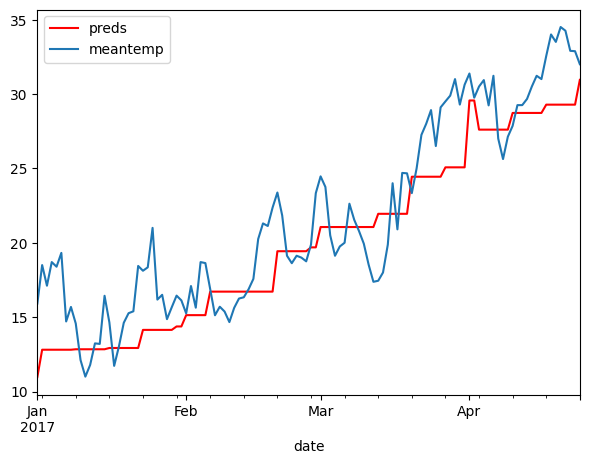

In [31]:
visualise_preds(dfcp_test, X_test, mean_temp_reg, target)